In [1]:
import os

import numpy as np
import seaborn as sns
import pandas as pd
import pickle as pkl

from pathlib import Path
from tqdm import tqdm
from loguru import logger
import matplotlib.pyplot as plt
import warnings

plt.rcParams["figure.figsize"] = (16, 9)

In [2]:
warnings.simplefilter("ignore")

In [3]:
os.chdir("..")

In [4]:
from engine.trainer import TrainingResults

## Preprocessing

In [5]:
results_path = Path("results")

lenet_path = results_path / "lenet_theoretical"
mlp_path = results_path / "mlp_theoretical"

In [6]:
def results_to_df(res: TrainingResults) -> pd.DataFrame:
    subdfs = []

    for idx, res_items in enumerate(
        zip(res.optimal_lrs, res.scheduler_lrs, res.losses)
    ):
        subdf = pd.DataFrame()
        lrs = res_items[0]
        for key, item in lrs.items():
            elements = key.split(".")
            layer_num, layer_item = elements[1], elements[2]
            row = pd.DataFrame(
                data={
                    "iter": [idx],
                    "layer": [layer_num],
                    "layer_el": [layer_item],
                    "lr_optim": [float(item)],
                    "scheduler_lr": [float(res_items[1][key])],
                }
            )
            subdf = pd.concat([subdf, row])

        subdfs.append(subdf)

    return pd.concat(subdfs)


def losses_to_df(res: TrainingResults) -> pd.DataFrame:
    df = pd.DataFrame(data={"loss": res.losses})
    df.reset_index(inplace=True)
    df.rename(columns={"index": "iter"}, inplace=True)
    return df

In [10]:
output_path = Path("results/theoretical_results_merged.csv")
if not output_path.is_file():
    dirs = {
        "lenet": {
            "constant": lenet_path / "Constant",
            "one_cycle": lenet_path / "OneCycle",
            "super_convergence": lenet_path / "SuperConvergence",
        },
        "mlp": {
            "constant": mlp_path / "Constant",
            "one_cycle": mlp_path / "OneCycle",
            "super_convergence": mlp_path / "SuperConvergence",
        },
    }

    for model_name, training_types in dirs.items():
        for training_name, results_dir in training_types.items():
            print(results_dir)
            logger.info(f"Start {model_name}-{training_name}")
            files = results_dir.glob("results*")

            for filename in tqdm(files):
                with open(filename, "rb") as f:
                    res = pkl.load(f)

                losses = losses_to_df(res)

                df = results_to_df(res)
                df["filename"] = filename.stem
                df["model"] = model_name
                df["training_type"] = training_name

                df = df.merge(losses, on="iter")

                df.to_csv(
                    f"results-{filename.stem}-{model_name}-{training_name}.csv",
                    index=False,
                )

    dfs = []
    result_paths = Path(".").glob("*.csv")
    for result_path in result_paths:
        df = pd.read_csv(result_path)
        dfs.append(df)

    df_all = pd.concat(dfs)

    df_all.to_csv(output_path, index=False)
else:
    df_all = pd.read_csv(output_path)
    
df_all.training_type = df_all.training_type.map({'constant': 'Constant', 'one_cycle': 'OneCycle', 'super_convergence': 'SuperConv'})
df_all.model = df_all.model.map({'lenet': 'LeNet', 'mlp': 'MLP'}, )
    
df_all

,iter,layer,layer_el,lr_optim,scheduler_lr,filename,model,training_type,loss
0,0,0,weight,0.013477,1.000000e-02,results_7,LeNet,Constant,2.302785
1,0,0,bias,0.004340,1.000000e-02,results_7,LeNet,Constant,2.302785
2,0,3,weight,0.014851,1.000000e-02,results_7,LeNet,Constant,2.302785
3,0,3,bias,0.016545,1.000000e-02,results_7,LeNet,Constant,2.302785
4,0,7,weight,0.013367,1.000000e-02,results_7,LeNet,Constant,2.302785
...,...,...,...,...,...,...,...,...,...
6752155,14066,7,bias,0.000000,0.000000e+00,results_7,LeNet,SuperConv,1.562578
6752156,14066,9,weight,0.002786,2.758631e-06,results_7,LeNet,SuperConv,1.562578
6752157,14066,9,bias,0.000000,0.000000e+00,results_7,LeNet,SuperConv,1.562578
6752158,14066,11,weight,0.000002,4.985176e-07,results_7,LeNet,SuperConv,1.562578


## Viz utils

In [14]:
def get_plot_per_layer_ratio(df: pd.DataFrame, model: str, n_cols: int = 3):
    plt.clf()
    df = df[df["model"] == model]

    layers_ids = df["layer"].unique()
    n_rows = int(np.ceil(len(layers_ids) / n_cols))

    _, axes = plt.subplots(n_rows, n_cols)

    for idx, layer_id in enumerate(layers_ids):
        df_temp = df[df["layer"] == layer_id]
        df_temp.loc[:, "lr_ratio"] = (
            df_temp["lr_optim"] / df_temp["scheduler_lr"]
        )
        df_temp["const"] = 1
        sns.lineplot(
            df_temp,
            x="iter",
            y="lr_ratio",
            hue="layer_el",
            ax=axes[idx // n_cols, idx % n_cols],
        ).set(title=f"Layer={layer_id}", yscale="log")
        sns.lineplot(
            df_temp,
            x="iter",
            y="const",
            ax=axes[idx // n_cols, idx % n_cols],
            color="r",
        ).set()

    plt.suptitle(
        "Ratio of the optimal and actually used learning rate (logscale)"
    )


def get_plot_per_layer(df: pd.DataFrame, model: str, title: str, n_cols: int = 3):
    plt.clf()
    df = df[df["model"] == model]

    layers_ids = df["layer"].unique()
    n_rows = int(np.ceil(len(layers_ids) / n_cols))

    _, axes = plt.subplots(n_rows, n_cols)

    for idx, layer_id in enumerate(layers_ids):
        df_temp = df[df["layer"] == layer_id]
        sns.lineplot(
            df_temp,
            x="iter",
            y="lr_optim",
            hue="layer_el",
            ax=axes[idx // n_cols, idx % n_cols],
        ).set(title=f"Layer={layer_id}")
        sns.lineplot(
            df_temp,
            x="iter",
            y="scheduler_lr",
            ax=axes[idx // n_cols, idx % n_cols],
            color="r",
        ).set()
        
    if len(layers_ids) < n_cols * n_rows:
        axes[n_rows-1, n_cols-1].axis('off')

    plt.suptitle(title)


def get_plot_of_super_convergence_lr(
    df: pd.DataFrame, model: str, title: str, n_cols: int = 3
):
    plt.clf()
    df = df[df["model"] == model]

    layers_ids = df["layer"].unique()
    n_rows = int(np.ceil(len(layers_ids) / n_cols))

    _, axes = plt.subplots(n_rows, n_cols)

    for idx, layer_id in enumerate(layers_ids):
        df_temp = df[df["layer"] == layer_id]
        sns.lineplot(
            df_temp,
            x="iter",
            y="scheduler_lr",
            hue="layer_el",
            ax=axes[idx // n_cols, idx % n_cols],
            color="r",
        ).set(title=f"Layer={layer_id}")
        
    if len(layers_ids) < n_cols * n_rows:
        axes[n_rows-1, n_cols-1].axis('off')

    plt.suptitle(title)

## LeNet Analysis

## Losses analysis

Text(0.5, 1.0, 'Comparison of losses across LR scheduling strategies')

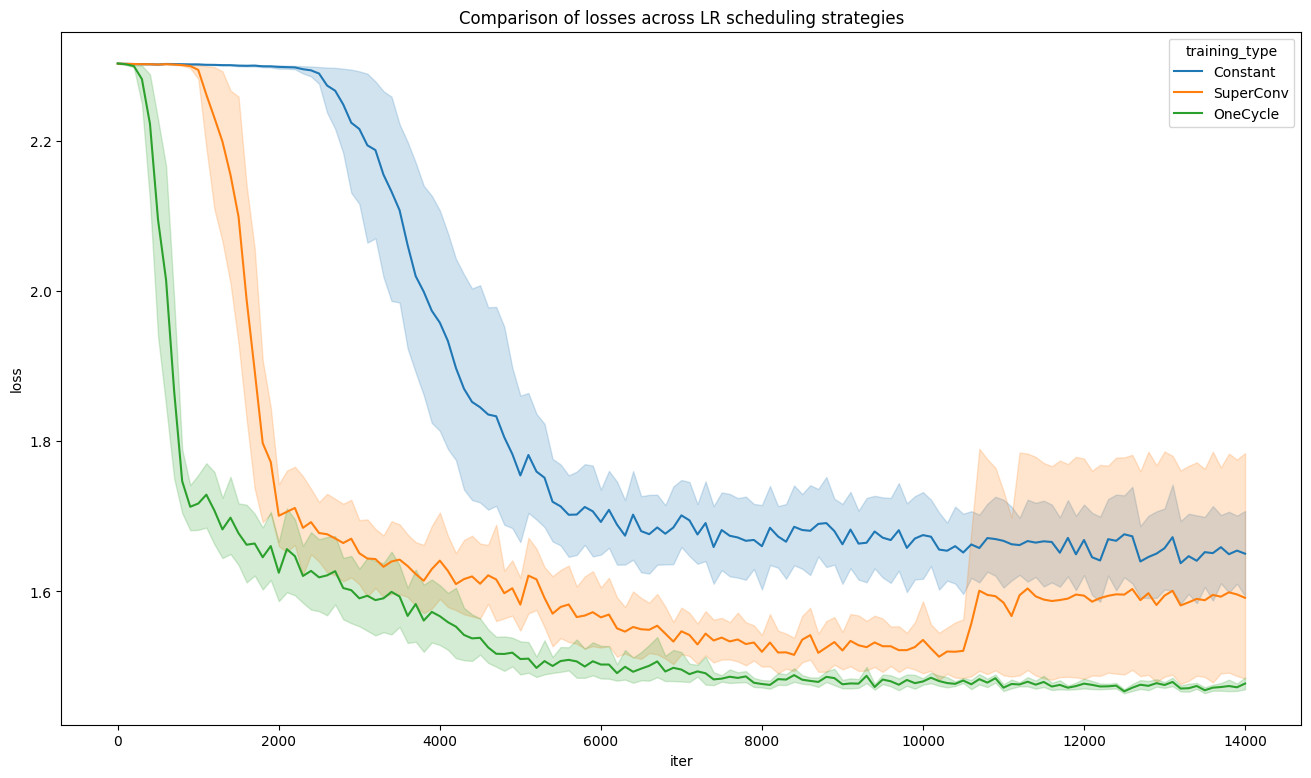

In [12]:
plot = sns.lineplot(
    data=df_all.loc[
        (df_all.iter % 100 == 0) & (df_all.model == "LeNet"),
        ["iter", "loss", "training_type", "filename"],
    ].drop_duplicates(),
    x="iter",
    y="loss",
    hue="training_type",
)
plot.set_title("Comparison of losses across LR scheduling strategies")

### Constant

<Figure size 1600x900 with 0 Axes>

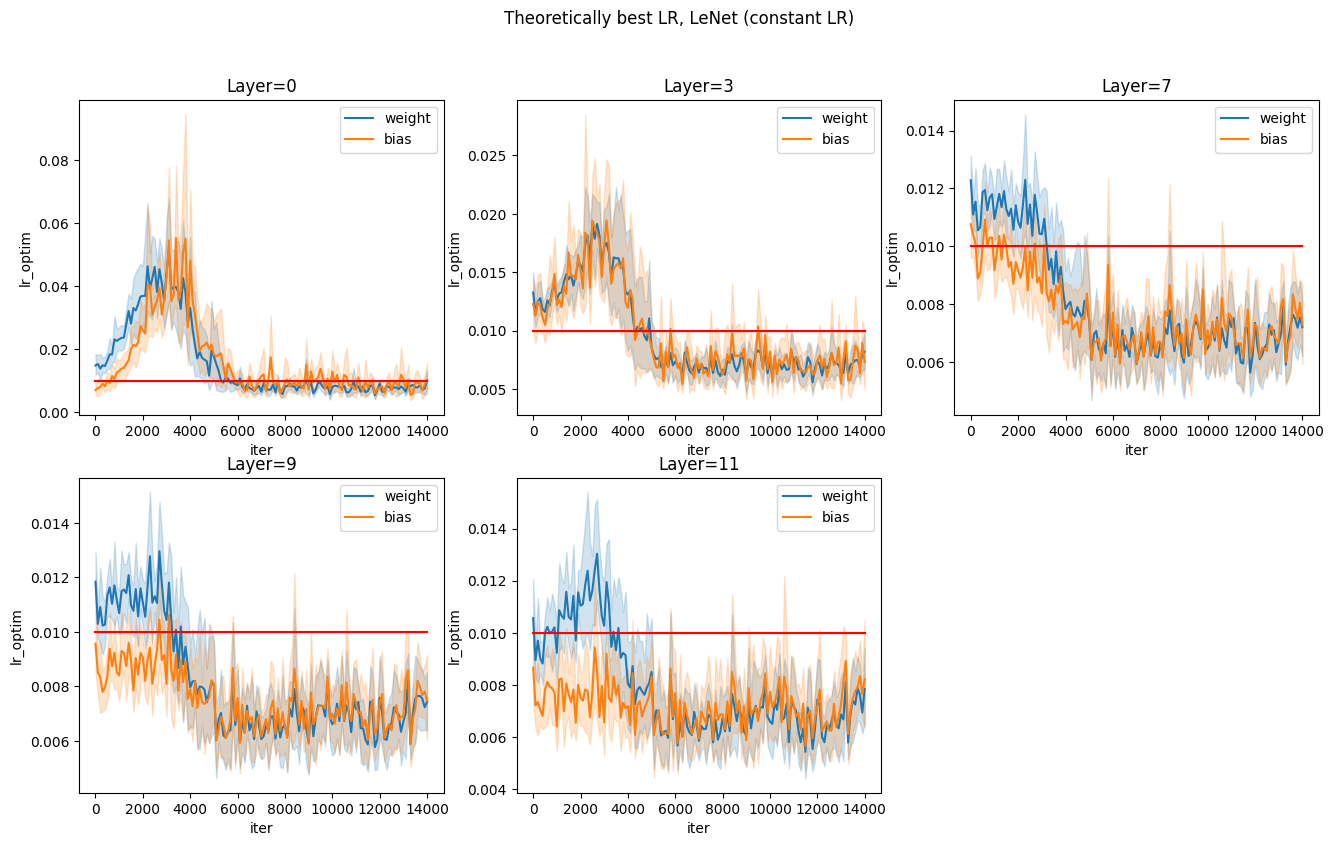

In [15]:
tmp = df_all[df_all["training_type"] == "Constant"]
tmp = tmp[tmp["iter"] % 100 == 0]

g = get_plot_per_layer(tmp, "LeNet", 'Theoretically best LR, LeNet (constant LR)')


### OneCycle

<Figure size 1600x900 with 0 Axes>

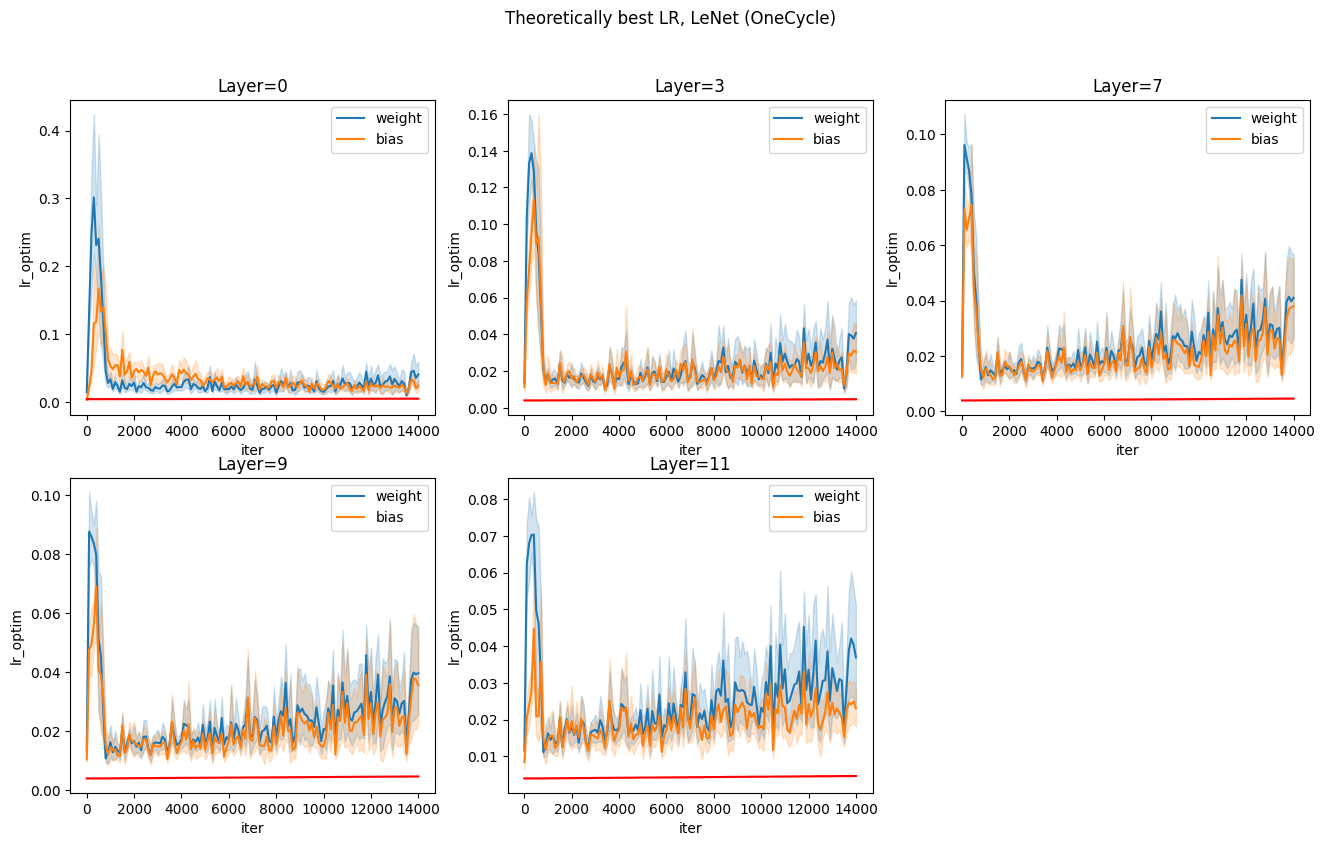

In [17]:
tmp = df_all[df_all["training_type"] == "OneCycle"]
tmp = tmp[tmp["iter"] % 100 == 0]

g = get_plot_per_layer(tmp, "LeNet", 'Theoretically best LR, LeNet (OneCycle)')
g

### SuperConvergence

<Figure size 1600x900 with 0 Axes>

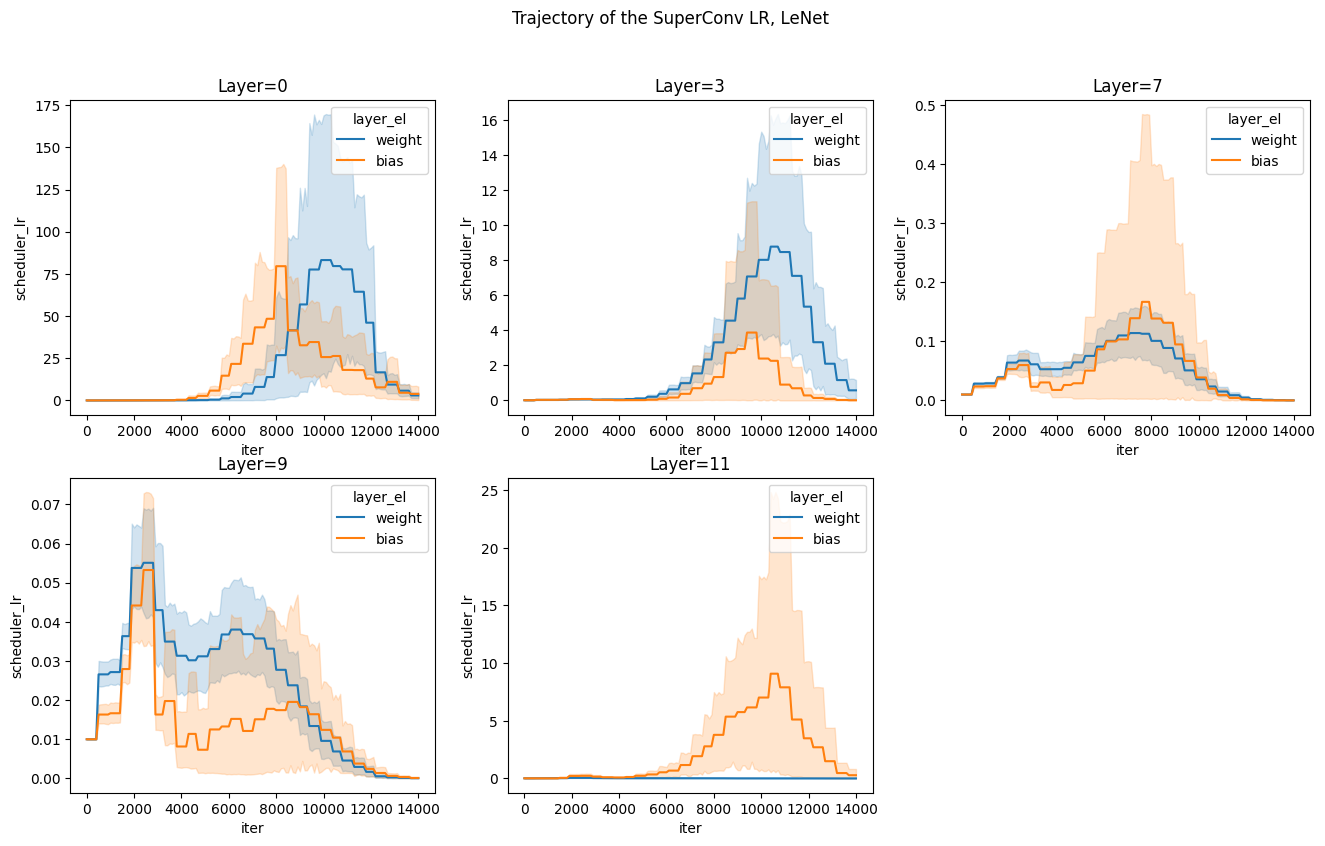

In [26]:
tmp = df_all[df_all["training_type"] == "SuperConv"]
tmp = tmp[(tmp["iter"] % 100 == 0)]
g = get_plot_of_super_convergence_lr(tmp, "LeNet", 'Trajectory of the SuperConv LR, LeNet')
g

## MLP analysis

## Loss

Text(0.5, 1.0, 'Comparison of losses across lr scheduling strategies')

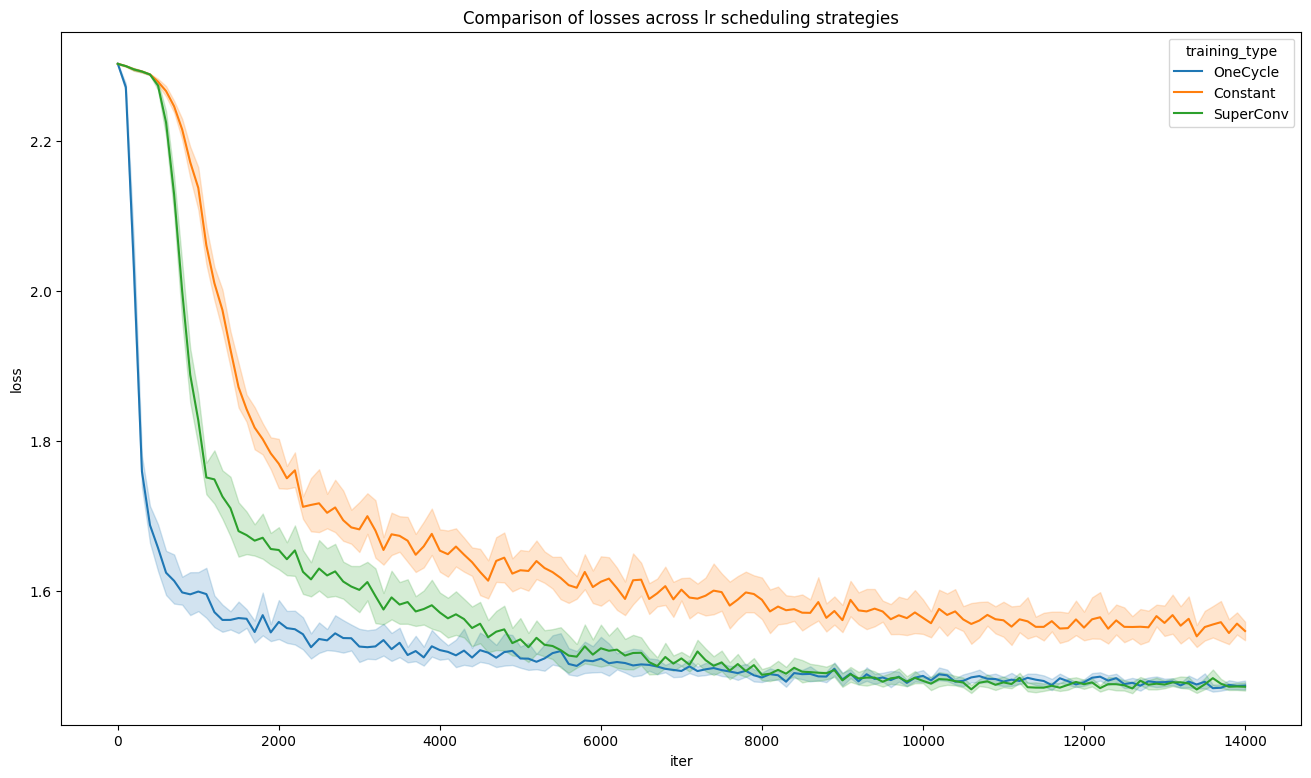

In [19]:
plot = sns.lineplot(
    data=df_all.loc[
        (df_all.iter % 100 == 0) & (df_all.model == "MLP"),
        ["iter", "loss", "training_type", "filename"],
    ].drop_duplicates(),
    x="iter",
    y="loss",
    hue="training_type",
)
plot.set_title("Comparison of losses across lr scheduling strategies")

### Constant

<Figure size 1600x900 with 0 Axes>

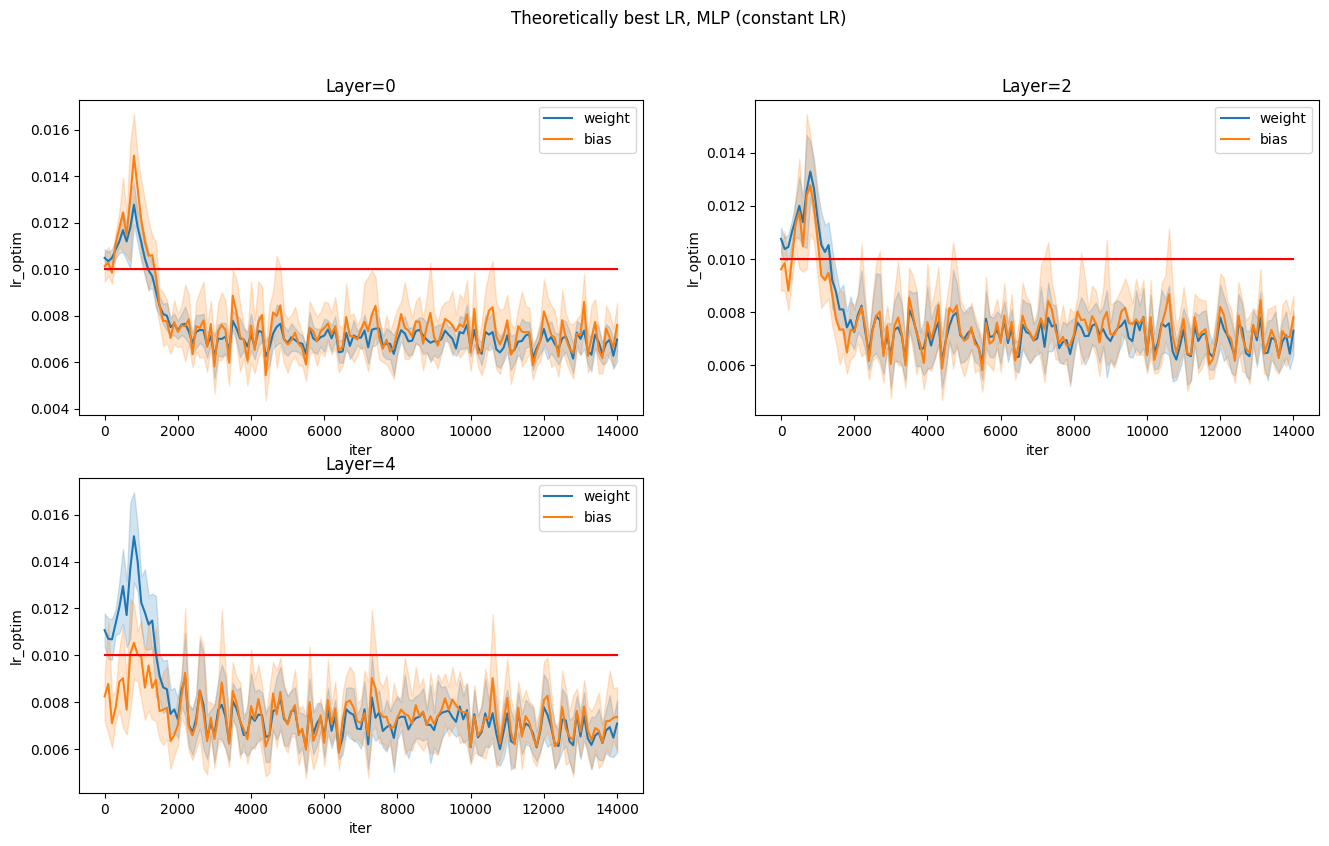

In [23]:
tmp = df_all[df_all["training_type"] == "Constant"]
tmp = tmp[tmp["iter"] % 100 == 0]

g = get_plot_per_layer(tmp, "MLP", 'Theoretically best LR, MLP (constant LR)', n_cols=2)
g

### OneCycle

<Figure size 1600x900 with 0 Axes>

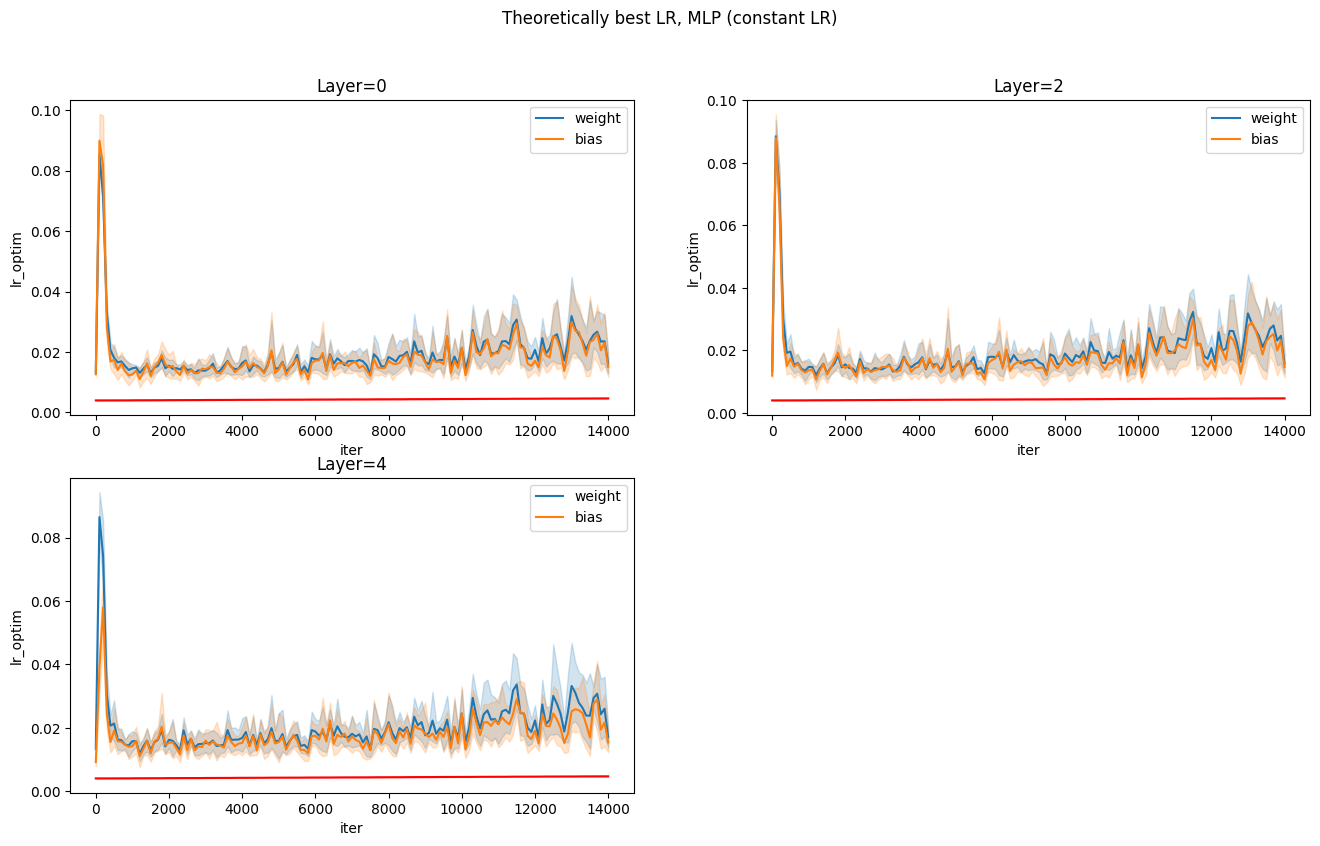

In [24]:
tmp = df_all[df_all["training_type"] == "OneCycle"]
tmp = tmp[tmp["iter"] % 100 == 0]

g = get_plot_per_layer(tmp, "MLP", 'Theoretically best LR, MLP (constant LR)', n_cols=2)
g

### SuperConvergence

<Figure size 1600x900 with 0 Axes>

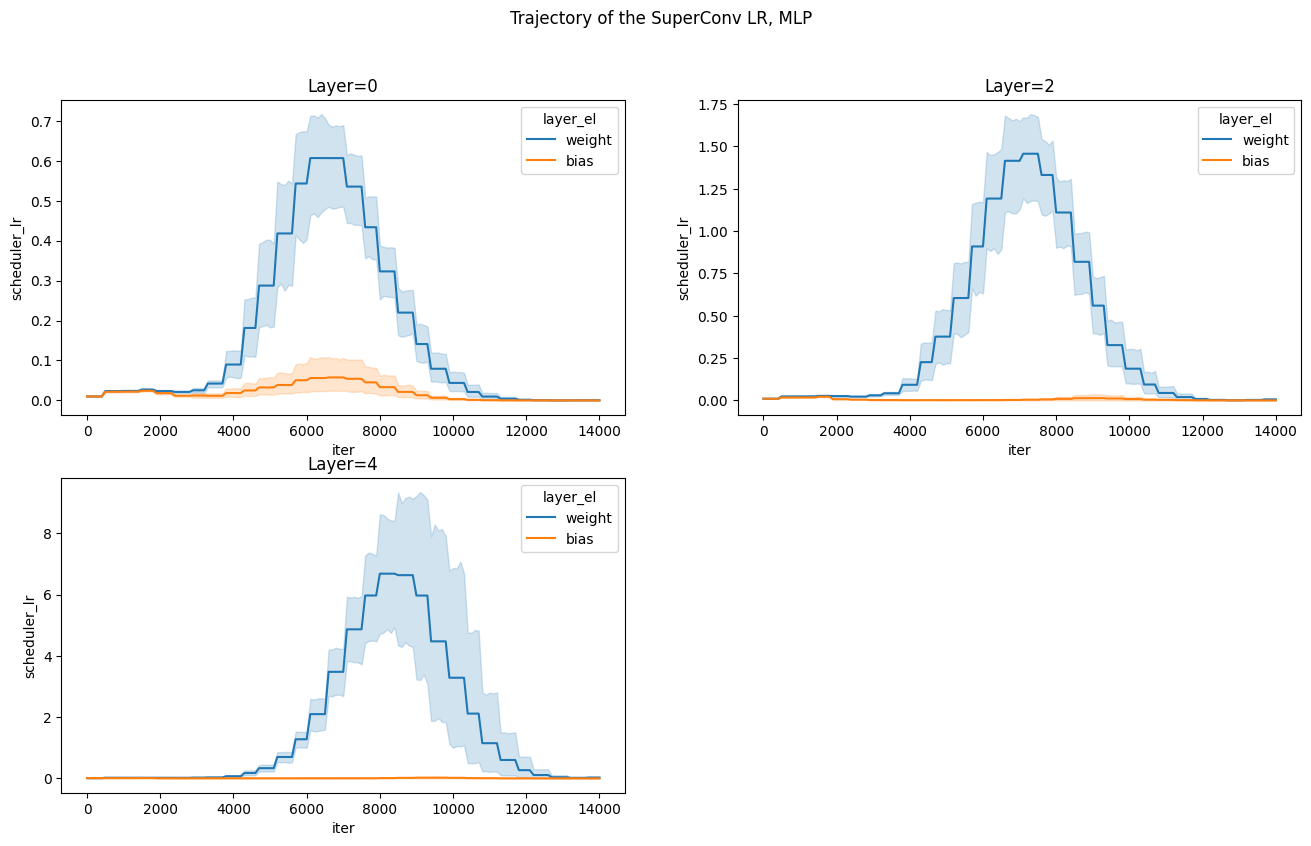

In [30]:
tmp = df_all[df_all["training_type"] == "SuperConv"]
tmp = tmp[(tmp["iter"] % 100 == 0)]
g = get_plot_of_super_convergence_lr(tmp, "MLP", 'Trajectory of the SuperConv LR, MLP', n_cols=2)
g